Code based on https://github.com/blei-lab/variational-smc.

In [1]:
using Random, LinearAlgebra, Distributions, Plots #ForwardDiff
using AutoGrad

In [2]:
mutable struct LGSS_SMC
    T::Integer     # Length of sequence
    dimX::Integer # Dimension of latent variables
    dimY::Integer # Dimension of observations
    N::Integer     # Number of particles
    
    sim_prop # Function for sampling from proposal
    log_weights # Function for computing weights
end

In [14]:
# TODO: fix seed

function resampling(W)
    # TODO: this isn't the resampling algorithm described in the paper?
    # Taking indices, adding uniform noise, then dividing by N, and re-fitting them into bins
    N = size(W)[1]
    bins = cumsum(W,dims=1)#cumsum(W[:,1])
    ind = 0:N-1
    u = (ind + rand(N)) / N
    digitize = i -> searchsortedfirst(bins[:,1],i)
    return digitize.(u)
    #cat = Categorical(W[:,1])
    #return rand(cat,N)
end
@zerograd resampling(W)

function vsmc_lower_bound(prop_params, model_params, y, smc_obj; verbose=false, adapt_resamp=false)
    # Extract constants
    T = size(y)[1]
    dimX = smc_obj.dimX
    N = smc_obj.N
    
    # Initialize SMC
    X = zeros(N,dimX)
    X_anc = zeros(N,dimX)
    logW = zeros(N)
    W = exp.(logW) / N
    logZ = 0
    ESS = (1/sum(W.^2)) / N # Effective sample size divided by N
    
    for t in 1:T
        # Resampling
        if adapt_resamp
            # TODO
        else
            if t > 1
                ancestors = resampling(W)
                X_anc = X[ancestors,:]
            else
                X_anc = X
            end
        end
        
        # Propagation
        X = smc_obj.sim_prop(t, X_anc, y, prop_params, model_params)
        
        # Reweighting
        if adapt_resamp
            # TODO
        else
            #logW = vec(smc_obj.log_weights(t, X, Xp, y, prop_params, model_params))
            logW = smc_obj.log_weights(t, X, X_anc, y, prop_params, model_params)
        end
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        if adapt_resamp
            # TODO
        else
            logZ = logZ + max_logW + log(sum(W)) - log(N)
        end
        W /= sum(W)
        ESS = (1/sum(W.^2)) / N
    end
    if verbose
        println("ESS: ", ESS)
    end
    return logZ
end

vsmc_lower_bound (generic function with 1 method)

In [18]:
function init_model_params(dimX, dimY, α, r, obs)
    μ0 = zeros(dimX)
    Σ0 = Matrix{Float64}(I,dimX,dimX)
    
    A = zeros(dimX,dimX)
    for i in 1:dimX
        for j in 1:dimX
            A[i,j] = α^(abs(i-j)+1)
        end
    end
    
    Q = Matrix{Float64}(I,dimX,dimX)
    
    # TODO: obs
    # C = zeros(dimY,dimX)
    C = randn(dimY,dimX)
    
    R = r*Matrix{Float64}(I,dimY,dimY)
    
    return μ0, Σ0, A, Q, C, R
end

function init_prop_params(T, dimX, scale)
    return [(scale*randn(dimX), # Bias
            1 .+ scale*randn(dimX), # Linear times A/μ0
            scale*randn(dimX)) # Log-var
            for t in 1:T]
end

function generate_data(model_params, T)
    μ0, Σ0, A, Q, C, R = model_params
    dimX = size(μ0)[1]
    dimY = size(R)[1]
    
    x_true = zeros(T,dimX)
    y_true = zeros(T,dimY)
    
    for t in 1:T
        if t > 1
            x_dist = MvNormal(A*x_true[t-1,:],Q)
        else
            x_dist = MvNormal(μ0,Σ0)
        end
        x_true[t,:] = rand(x_dist,1)
        
        y_dist = MvNormal(C*x_true[t,:],R)
        y_true[t,:] = rand(y_dist,1)
    end
    
    return x_true, y_true
end

function log_marginal_likelihood(model_params, T, y_true)
    μ0, Σ0, A, Q, C, R = model_params
    dimX = size(μ0)[1]
    dimY = size(R)[1]
    
    # Compute via Kalman filter
    log_likelihood = 0
    
    x_filt = zeros(dimX)
    P_filt = zeros(dimX,dimX)
    x_pred = μ0
    P_pred = Σ0
    
    for t in 1:T
        if t > 1
            # Predict
            x_pred = A * x_filt
            P_pred = A*P_filt*A' + Q
        end
        
        # Update
        yt = y_true[t,:] - C*x_pred
        S = C*P_pred*C' + R
        K = (S \ (C*P_pred))'
        x_filt = x_pred + K*yt
        P_filt = P_pred - K*C*P_pred
        
        # TODO: double check this correct
        log_likelihood += -0.5*(dot(yt,S\yt) + logdet(S) + dimY*log(2*π))
    end
    return log_likelihood
end

function sim_prop(t, X_anc, y, prop_params, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    μt, lint, log_σ2t = prop_params[t]
    σt = sqrt.(exp.(log_σ2t))
    
    N, dimX = size(X_anc)
    
    if t > 1
        μ = μt' .+ (A*X_anc')'.* lint'
    else
        μ = (μt + lint.*μ0)'
    end
    return μ .+ randn(N,dimX) .* σt'
end

function log_normal(x,μ,Σ)
    dim = size(Σ)[1]
    log_norm = -0.5*dim*log(2*π) - 0.5*logdet(Σ)
    if size(x) == size(μ)
        diff = x - μ
    else
        diff = x .- μ'
    end
    prec = inv(Σ) # AutoGrad doesn't support backslash
    return log_norm .- 0.5*diag(diff*prec*diff') # Original code does sum here but that seems incorrect
end

function log_target(t, X, X_anc, y, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    if t > 1
        logF = log_normal(X,(A*X_anc')',Q)
    else
        logF = log_normal(X,μ0,Σ0)
    end
    logG = log_normal((C*X')',y[t],R)
    return logF + logG
end

function log_prop(t,X,X_anc,y,prop_params,model_params)
    μ0, Σ0, A, Q, C, R = model_params
    μt, lint, log_σ2t = prop_params[t]
    σ2t = exp.(log_σ2t)
    dimX = length(σ2t)
    if t > 1
        μ = μt' .+ (A*X_anc')'.* lint'
    else
        μ = μt + lint.*μ0
    end
    return log_normal(X,μ,Matrix{Float64}(I,dimX,dimX).*σ2t)#Matrix{Float64}(I,dimX,dimX) .* σ2t)
end

function log_weights(t, X, X_anc, y, prop_params, model_params)
    return log_target(t,X,X_anc,y,model_params) - log_prop(t,X,X_anc,y,prop_params,model_params)
    #N = size(X)[1]
    #return repeat([1/N],N)
end

log_weights (generic function with 1 method)

In [19]:
# Model hyperparameters
T = 10
dimX = 10
dimY = 3
α = 0.42
r = 1 #0.1
obs = "sparse"

# Training parameters
param_scale = 0.5
num_epochs = 1000
step_size = 0.001

N = 4

model_params = init_model_params(dimX, dimY, α, r, obs)

x_true, y_true = generate_data(model_params, T)
# println("True x: ", x_true)
# println("True y: ", y_true)

log_marginal = log_marginal_likelihood(model_params, T, y_true)
println("True log-marginal likelihood: ", log_marginal)

prop_params = init_prop_params(T, dimX, param_scale)

lgss_smc_obj = LGSS_SMC(T,dimX,dimY,N,sim_prop,log_weights)

println("VSMC lower bound: ",vsmc_lower_bound(prop_params, model_params, y_true, lgss_smc_obj))

function rho(iter,∇L,ss;δ=1e-16,t=0.1,η=0.1)
    s = t*(∇L)^2+(1-t)*ss
    ρ = η*iter^(-1/2+δ)*(1+sqrt(s))^(-1)
    return s,ρ
end

function flatten_prop_params(prop_params)
    T = length(prop_params)
    dimX = length(prop_params[1][1])
    dimλ = 3*T*dimX
    flat_params = zeros(dimλ)
    k = 3*dimX
    for i in 1:T
        flat_params[(1+k*(i-1)):(k+k*(i-1))] .= (prop_params[i][1]...,prop_params[i][2]...,prop_params[i][3]...)
    end
    return flat_params, dimλ
end

function reshape_flat_params(flat_params, prop_params)
    T = length(prop_params)
    dimX = length(prop_params[1][1])
    k = 3*dimX
    return [(flat_params[(1+k*(i-1)):(dimX+k*(i-1))],
             flat_params[(1+dimX+k*(i-1)):(2*dimX+k*(i-1))],
             flat_params[(1+2*dimX+k*(i-1)):(k+k*(i-1))]) for i in 1:T]
end


function objective(flat_params,prop_params)
    reshaped_params = reshape_flat_params(flat_params,prop_params)
    return vsmc_lower_bound(reshaped_params, model_params, y_true, lgss_smc_obj)
end

flat_params, dimλ = flatten_prop_params(prop_params)

True log-marginal likelihood: -83.5656960431447
VSMC lower bound: -173.60504217065903


([0.23868242262731554, -0.1863299150778547, 0.4097885157358862, 0.9214055809404339, 0.8789098631802545, 0.3701930676383827, 0.29616710211192915, -0.49667991657859284, 0.7266827223771943, -0.5005724257871648  …  -0.18601837085414905, -0.5577263586081145, -0.26943163189135205, 0.2953656223753807, 0.5842185448860072, -0.9909060025826238, -0.6506548949279718, -0.2393943351471281, 0.44448228386736544, -0.2509015320371889], 300)

VSMC bound: -107.88516034022273


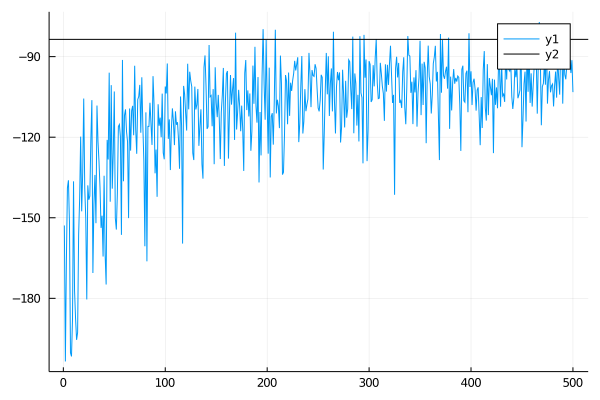

In [20]:
iters = 500
λs = zeros(iters,dimλ)
λs[1,:] = flat_params
vsmcb = zeros(iters)
vsmcb[1] = vsmc_lower_bound(prop_params,model_params,y_true,lgss_smc_obj)
ss = ones(iters,dimλ)
#ρs = zeros(iters)

∇objective = grad(objective)
for i in 1:iters-1
    ∇λ = ∇objective(λs[i,:],prop_params) #ForwardDiff.gradient(λ->objective(λ,prop_params),λs[i,:])
    for j in 1:dimλ
        s,ρ = rho(i,∇λ[j],ss[i,j])
        ss[i+1,j] = s
        λs[i+1,j] = λs[i,j] + ρ*∇λ[j]
    end
    vsmcb[i+1] = vsmc_lower_bound(reshape_flat_params(λs[i+1,:],prop_params),model_params,y_true,lgss_smc_obj)
end
final_params = reshape_flat_params(λs[iters,:],prop_params)
println("VSMC bound: ", vsmc_lower_bound(final_params,model_params,y_true,lgss_smc_obj))
plot(1:iters,vsmcb)
hline!([log_marginal], linecolor=:black)

In [7]:
using HTTP: request

"https://gist.githubusercontent.com/vankesteren/96207abcd16ecd01a2491bcbec12c73f/raw/1b59af6962a1107db5873eba59054acc3f9a8aac/Adamopt.jl" |>
  url -> request("GET", url) |> 
  res -> String(res.body) |> 
  str -> include_string(Main, str)

using .Adamopt


iters_adam = 500
loss = λ -> -vsmc_lower_bound(reshape_flat_params(λ,prop_params),model_params,y_true,lgss_smc_obj)
grad = λ -> -ForwardDiff.gradient(λ->objective(λ,prop_params),λ)
dopt = Adam(flat_params,loss,grad)
dopt.a = 0.01
vsmc_adam = zeros(iters_adam)
for i = 1:iters_adam
    step!(dopt)
    vsmc_adam[i] = -dopt.loss(dopt.theta)
    #print(string("Step: ", dopt.t, " | Loss: ", dopt.loss(dopt.theta), "\n"))
end
final_adam_params = reshape_flat_params(dopt.theta,prop_params)
println("VSMC bound: ", vsmc_lower_bound(final_adam_params,model_params,y_true,lgss_smc_obj))
plot(1:iters_adam,vsmc_adam)
hline!([log_marginal], linecolor=:black)

LoadError: [91mcannot assign a value to variable AutoGrad.grad from module Main[39m